In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob

In [2]:
cosmo_keys = {}
cosmo_comm = {}

# Cosmology
# IST:Forecast cosmological model
# Customize at wish... Default is Flaghip cosmology

#COSMO_ID
cosmo_keys["COSMO_ID"] = "LCDM"
cosmo_comm["COSMO_ID"] = "Identifier for the cosmology used"

#Matter energy density
cosmo_keys["OMEGA_M"] = 0.318563
cosmo_comm["OMEGA_M"] = "Matter energy density"

#Radiation energy density
cosmo_keys["OMEGA_R"] = 0.0
cosmo_comm["OMEGA_R"] = "Radiation energy density"

#Baryon energy density
cosmo_keys["OMEGA_B"] = 0.05
cosmo_comm["OMEGA_B"] = "Baryon energy density"

#Vacuum energy density
cosmo_keys["OMEGA_V"] = 0.68
cosmo_comm["OMEGA_V"] = "Vacuum energy density"

#Curvature energy density
cosmo_keys["OMEGA_K"] = 0.0
cosmo_comm["OMEGA_K"] = "Curvature energy density"

#Hubble parameter in 100 Km/s/(Mpc/h)
cosmo_keys["HUBBLE"] = 0.67
cosmo_comm["HUBBLE"] = "Hubble parameter in 100 Km/s/(Mpc/h)"

#Scalar index of primordial perturbations
cosmo_keys["INDEX_N"] = 0.96
cosmo_comm["INDEX_N"] = "Scalar index of primordial perturbations"

#Mass dispersion on 8 Mpc/h sphere
cosmo_keys["SIGMA_8"] = 0.816
cosmo_comm["SIGMA_8"] = "Mass dispersion on 8 Mpc/h sphere"

#Dark energy equation of state
cosmo_keys["W_STATE"] = -1
cosmo_comm["W_STATE"] = "Dark energy equation of state"

#Effective number of relativistic species
cosmo_keys["N_EFF"] = 2.03
cosmo_comm["N_EFF"] = "Effective number of relativistic species"

#CMB temperature
cosmo_keys["T_CMB"] = 2.726
cosmo_comm["T_CMB"] = "CMB temperature"

def add_cosmo_keywords (hdu):
        
    for key in cosmo_keys:
        hdu.header[key] = cosmo_keys[key]
        hdu.header.comments[key] = cosmo_comm[key]


In [3]:
pk_files = glob.glob("Sefusatti_multipoles_pk/*galaxies*.dat")

for ascii_name in pk_files:
    fits_name_pk = ascii_name.replace(".dat", ".fits")
    fits_name_pk_cov = fits_name_pk.replace("power", "cov_power")
    
    #Read pk multipoles and errors from file
    kk, pk0, epk0, pk2, epk2, pk4, epk4 = np.genfromtxt(ascii_name, unpack=True)
    
    l1, l2, k1, k2, cov = [], [], [], [], []

    for _l1 in [0, 2, 4]:
        for i, _k1 in enumerate(kk):
            for _l2 in [0, 2, 4]:
                for j, _k2 in enumerate(kk):
                    l1.append(_l1)
                    l2.append(_l2)
                    k1.append(_k1)
                    k2.append(_k2)
                    #P(k) covariance is diagonal!
                    if (_l1==_l2) & (i==j):
                        cov.append(globals()["epk%d"%_l1][i]**2)
                    else:
                        cov.append(0)
                        
    #Write P(k) product-like file
    hdu_list = fits.HDUList()
    
    #Create columns and add in "SPECTRUM" table extension
    col_k = fits.Column(name="K", format="D", array = kk)
    col_pk0 = fits.Column(name="PK0", format="D", array = pk0)
    col_pk2 = fits.Column(name="PK2", format="D", array = pk2)
    col_pk4 = fits.Column(name="PK4", format="D", array = pk4)
    col_mod = fits.Column(name="MOD", format="D", array = np.ones(len(kk)))

    col_defs = fits.ColDefs([col_k, col_pk0, col_pk2, col_pk4, col_mod])
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "SPECTRUM"
    
    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    #Write table extension to file
    hdu_list.append(hdu)
    hdu_list.writeto(fits_name_pk, overwrite=True)
    
    #Write Pk covariance "product"
    
    hdu_list = fits.HDUList()
    
    #Create columns and add in "AVERAGE" table extension

    col_k = fits.Column(name="SCALE_1DIM", format="D", array = kk)
    col_pk0 = fits.Column(name="AVERAGE0", format="D", array = pk0)
    col_pk2 = fits.Column(name="AVERAGE2", format="D", array = pk2)
    col_pk4 = fits.Column(name="AVERAGE4", format="D", array = pk4)
    col_defs = fits.ColDefs([col_k, col_pk0, col_pk2, col_pk4])
    
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "AVERAGE"

    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    hdu_list.append(hdu)
    
    #Create columns and add them in "COVARIANCE" table extension

    col_k1 = fits.Column(name="SCALE_1DIM-I", format="D", array = k1)
    col_l1 = fits.Column(name="MULTIPOLE-I", format="D", array = l1)
    col_k2 = fits.Column(name="SCALE_1DIM-J", format="D", array = k2)
    col_l2 = fits.Column(name="MULTIPOLE-J", format="D", array = l2)
    col_cov = fits.Column(name="COVARIANCE", format="D", array = cov)
    
    col_defs = fits.ColDefs([col_k1, col_l1, col_k2, col_l2, col_cov])
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "COVARIANCE"

    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    hdu_list.append(hdu)

    hdu_list.writeto(fits_name_pk_cov, overwrite=True)

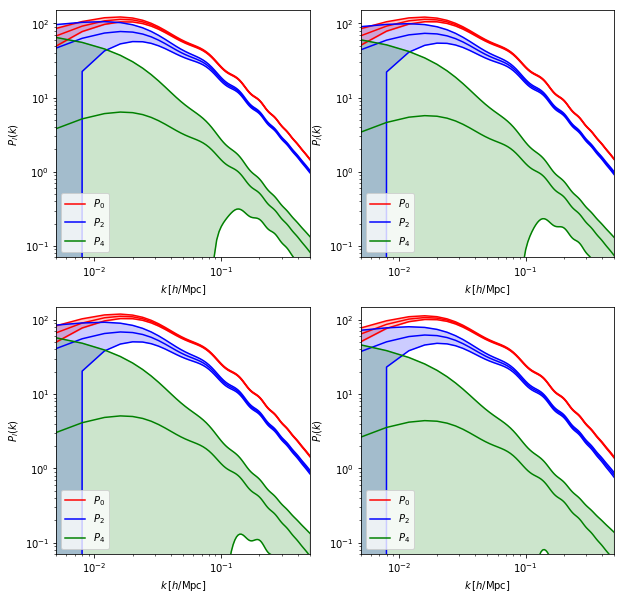

In [4]:
root_name = "../data/Sefusatti_multipoles_pk/cov_power_galaxies_dk0p004_z1.%s.fits"

zstr = ["", "2", "4", "65"]
figure, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, zz in enumerate(zstr):
    fits_file = fits.open(root_name%zz)
    
    average = fits_file[1].data
    kk, pk0, pk2, pk4 = average["SCALE_1DIM"], average["AVERAGE0"], average["AVERAGE2"], average["AVERAGE4"]
    cov = fits_file[2].data["COVARIANCE"]
    nk = len(kk)    
    cov = np.reshape(cov, newshape=(3*nk, 3*nk))

    err = np.sqrt(np.diagonal(cov))
    epk0, epk2, epk4 = err[0:nk], err[nk:2*nk], err[2*nk:]

    ax[i].set_xscale("log")
    ax[i].set_xlim([0.005, 0.5])
    ax[i].set_xlabel(r"$k \, [h/\mathrm{Mpc}]$")

    ax[i].set_yscale("log")
    ax[i].set_ylim([0.07, 150])
    ax[i].set_ylabel(r"$P_l(k)$")
    
    ax[i].plot(kk, pk0, "-r", label=r"$P_0$")
    ax[i].plot(kk, pk0-epk0, "-r")
    ax[i].plot(kk, pk0+epk0, "-r")

    ax[i].plot(kk, pk2, "-b", label=r"$P_2$")
    ax[i].plot(kk, pk2-epk2, "-b")
    ax[i].plot(kk, pk2+epk2, "-b")
    
    ax[i].plot(kk, pk4, "-g", label=r"$P_4$")
    ax[i].plot(kk, pk4-epk4, "-g")
    ax[i].plot(kk, pk4+epk4, "-g")

    ax[i].fill_between(kk, pk0-epk0, pk0+epk0, color="r", alpha=0.2)
    ax[i].fill_between(kk, pk2-epk2, pk2+epk2, color="b", alpha=0.2)
    ax[i].fill_between(kk, pk4-epk4, pk4+epk4, color="g", alpha=0.2)
    
    ax[i].legend(loc="lower left")

In [7]:
xi_files = glob.glob("../data/Marulli_multipoles/dataset*0.dat")
cov_files = glob.glob("../data/Marulli_multipoles/dataset*e.dat")

for ascii_name_xi, ascii_name_cov in zip(xi_files, cov_files):

    fits_name_xi = ascii_name_xi.replace(".dat", ".fits")
    fits_name_xi_cov = ascii_name_cov.replace(".dat", ".fits")

    rr, xi0, exi0, xi2, exi2, xi4, exi4 = np.genfromtxt(ascii_name_xi, unpack=True, usecols=(0, 1, 2, 3, 4, 5, 6))
    err = np.array([exi0, exi2, exi4]).flatten()

    r1, r2, corr = np.genfromtxt(ascii_name_cov, unpack=True, usecols=(0, 1, 3))
    cov = corr * np.outer(err, err).flatten()

    l1, l2 = [], []

    for _l1 in [0, 2, 4]:
        for i, _r1 in enumerate(rr):
            for _l2 in [0, 2, 4]:
                for j, _r2 in enumerate(rr):
                    l1.append(_l1)
                    l2.append(_l2)
                    
    #Write Xi "product"

    hdu_list = fits.HDUList()
    
    col_rr = fits.Column(name="SCALE_1DIM", format="D", array = rr, unit="Mpc/h")
    col_xi0 = fits.Column(name="XI0", format="D", array = xi0)
    col_xi2 = fits.Column(name="XI2", format="D", array = xi2)
    col_xi4 = fits.Column(name="XI4", format="D", array = xi4)

    col_defs = fits.ColDefs([col_rr, col_xi0, col_xi2, col_xi4])
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "CORRELATION"

    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    hdu_list.append(hdu)
    hdu_list.writeto(fits_name_xi, overwrite=True)

    #Write Xi covariance "product"
    
    hdu_list = fits.HDUList()
    
    col_rr = fits.Column(name="SCALE_1DIM", format="D", array = rr, unit="Mpc/h")
    col_xi0 = fits.Column(name="AVERAGE0", format="D", array = xi0)
    col_xi2 = fits.Column(name="AVERAGE2", format="D", array = xi2)
    col_xi4 = fits.Column(name="AVERAGE4", format="D", array = xi4)
    
    col_defs = fits.ColDefs([col_rr, col_xi0, col_xi2, col_xi4])
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "AVERAGE"
    
    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    hdu_list.append(hdu)

    col_r1 = fits.Column(name="SCALE_1DIM-I", format="D", array = r1, unit="Mpc/h")
    col_l1 = fits.Column(name="MULTIPOLE-I", format="D", array = l1)
    col_r2 = fits.Column(name="SCALE_1DIM-J", format="D", array = r2, unit="Mpc/h")
    col_l2 = fits.Column(name="MULTIPOLE-J", format="D", array = l2)
    col_cov = fits.Column(name="COVARIANCE", format="D", array = cov)
    
    col_defs = fits.ColDefs([col_r1, col_l1, col_r2, col_l2, col_cov])
    hdu = fits.BinTableHDU.from_columns(col_defs)
    hdu.name = "COVARIANCE"

    #Add keywords with cosmological parameters
    add_cosmo_keywords(hdu)
    
    hdu_list.append(hdu)

    hdu_list.writeto(fits_name_xi_cov, overwrite=True)

['../data/Marulli_multipoles/dataset_1.30z1.50_covariance.fits', '../data/Marulli_multipoles/dataset_1.50z1.80_covariance.fits', '../data/Marulli_multipoles/dataset_1.10z1.30_covariance.fits', '../data/Marulli_multipoles/dataset_0.90z1.10_covariance.fits']


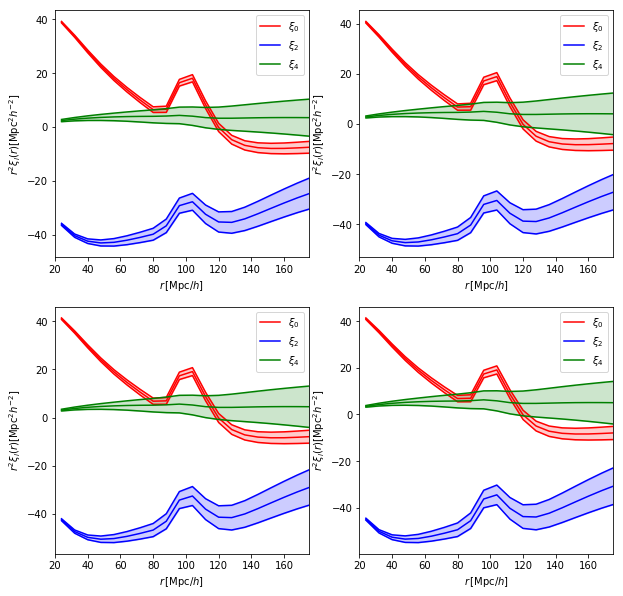

In [9]:
fits_file = glob.glob("../data/Marulli_multipoles/dataset*e.fits")

print(fits_file)

figure, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, ff in enumerate(fits_file):
    fits_file = fits.open(ff)
    
    average = fits_file[1].data
    rr, xi0, xi2, xi4 = average["SCALE_1DIM"], average["AVERAGE0"], average["AVERAGE2"], average["AVERAGE4"]
    cov = fits_file[2].data["COVARIANCE"]
    nr = len(rr) 
    
    cov = np.reshape(cov, newshape=(3*nr, 3*nr))
    
    err = np.sqrt(np.diagonal(cov))
    exi0, exi2, exi4 = err[0:nr], err[nr:2*nr], err[2*nr:]

    ax[i].set_xlim([20, 175])
    ax[i].set_xlabel(r"$r \, [\mathrm{Mpc} / h]$")

    ax[i].set_ylabel(r"$r^2 \xi_l(r) [\mathrm{Mpc}^2 h^{-2}]$")
    
    ax[i].plot(rr, rr**2*(xi0), "-r", label=r"$\xi_0$")
    ax[i].plot(rr, rr**2*(xi0-exi0), "-r")
    ax[i].plot(rr, rr**2*(xi0+exi0), "-r")
    
    ax[i].plot(rr, rr**2*(xi2), "-b", label=r"$\xi_2$")
    ax[i].plot(rr, rr**2*(xi2-exi2), "-b")
    ax[i].plot(rr, rr**2*(xi2+exi2), "-b")
    
    ax[i].plot(rr, rr**2*(xi4), "-g", label=r"$\xi_4$")
    ax[i].plot(rr, rr**2*(xi4-exi4), "-g")
    ax[i].plot(rr, rr**2*(xi4+exi4), "-g")

    ax[i].fill_between(rr, rr**2*(xi0-exi0), rr**2*(xi0+exi0), color="r", alpha=0.2)
    ax[i].fill_between(rr, rr**2*(xi2-exi2), rr**2*(xi2+exi2), color="b", alpha=0.2)
    ax[i].fill_between(rr, rr**2*(xi4-exi4), rr**2*(xi4+exi4), color="g", alpha=0.2)
    
    ax[i].legend(loc="upper right")
